# Chapter 1: 회전과 SE(3) 기초 - 이론에서 코드로 🚀

## 🎯 이번 실습의 목표

> **"3D 공간에서 로봇의 움직임을 코드로 다루는 법을 마스터하기"**

이론 강의에서 배운 SO(3), SE(3), Lie 군론의 개념들이 실제 코드에서 어떻게 구현되는지 직접 확인해봅시다. 특히 **SymForce와 nano-pgo**에서 사용하는 핵심 패턴들을 익히게 됩니다.

### 🔑 핵심 학습 내용
1. **회전 표현법 변환** - 언제 어떤 표현을 써야 할까?
2. **SE(3) 연산 구현** - 로봇 포즈를 안전하게 다루기
3. **Tangent Space 활용** - 최적화가 가능한 이유
4. **수치적 안정성** - epsilon이 구원하는 순간들
5. **SLAM 실전 응용** - 이 모든 것이 왜 필요한가

### 🏁 실습 시작 전 체크리스트
- [ ] 이론 강의 Chapter 1을 복습했나요?
- [ ] Python과 NumPy 기초를 알고 있나요?
- [ ] 3D 변환의 필요성을 이해했나요?

---

## 💡 이론과 실습의 연결고리

### 왜 여러 회전 표현법이 필요할까?

이론에서 배웠듯이, 각 표현법은 특정 상황에서 장점이 있습니다:

| 상황 | 최적 표현 | 실제 코드에서 |
|------|-----------|--------------|
| 3D 그래픽스 렌더링 | 회전 행렬 | `R @ point` 직접 계산 |
| 로봇 자세 제어 | 쿼터니언 | 짐벌락 회피, SLERP 보간 |
| SLAM 최적화 | 회전 벡터 | Tangent space에서 업데이트 |
| 센서 퓨전 | 쿼터니언 | 부드러운 자세 추정 |

### 🚨 실전 경험담
> "드론 프로젝트에서 오일러 각을 사용했다가, pitch가 90도 근처에서 제어가 폭주한 적이 있습니다. 쿼터니언으로 바꾸고 나서야 안정적인 비행이 가능했죠." - 실제 개발자

### 🔗 nano-pgo와의 연결
이번 실습에서 구현하는 함수들은 nano-pgo의 핵심 빌딩 블록입니다:
- `quat_to_rotmat()` → 시각화 및 벡터 변환
- `rotvec_to_quat()` → 최적화 업데이트 적용
- `SE3Transform` 클래스 → 포즈 그래프의 노드
- `relative_pose_error()` → 최적화 목적 함수

이제 코드로 들어가 봅시다!

## 🔧 필요한 라이브러리 설치 및 임포트

In [1]:
# 필요한 패키지들을 임포트합니다
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 출력 포맷 설정
np.set_printoptions(precision=4, suppress=True)

print("✅ 모든 라이브러리가 성공적으로 임포트되었습니다!")

✅ 모든 라이브러리가 성공적으로 임포트되었습니다!


## 1. 회전 표현법 간 변환 - 실전 구현 🔄

이론 강의 Section 2에서 배운 다양한 회전 표현법들을 실제 코드로 변환해봅시다. 

### 🎨 구현 패턴 이해하기

```
쿼터니언 [qx,qy,qz,qw] ←→ 회전 행렬 R (3x3)
         ↑                    ↓
         └── 회전 벡터 [rx,ry,rz] ←┘
```

각 변환 함수는 **scipy.spatial.transform.Rotation**을 활용합니다. 이는 수치적으로 안정적이고 검증된 구현입니다.

### ⚡ 실전 팁
- **쿼터니언 순서 주의**: `[qx, qy, qz, qw]` (스칼라가 마지막!)
- **회전 벡터**: 축 * 각도 형태로, 최적화에 최적
- **정규화 필수**: 쿼터니언은 항상 단위 길이 유지

### 🔍 코드 분석 포인트
아래 함수들을 구현하면서 다음을 주목하세요:
1. 각 표현법의 **차원** (쿼터니언 4D, 회전벡터 3D, 행렬 9D)
2. **특이점 처리** 여부
3. **계산 효율성**

In [2]:
def quat_to_rotmat(qx, qy, qz, qw):
    """쿼터니언을 회전 행렬로 변환
    
    Args:
        qx, qy, qz, qw: 쿼터니언 성분 (스칼라 부분이 qw)
        
    Returns:
        R: 3x3 회전 행렬
    """
    rotation = Rotation.from_quat([qx, qy, qz, qw])
    return rotation.as_matrix()

def rotvec_to_quat(rotvec):
    """회전 벡터를 쿼터니언으로 변환
    
    Args:
        rotvec: 3차원 회전 벡터 (축 * 각도)
        
    Returns:
        q: [qx, qy, qz, qw] 쿼터니언
    """
    rotation = Rotation.from_rotvec(rotvec)
    q = rotation.as_quat()
    return q

def rotmat_to_rotvec(R):
    """회전 행렬을 회전 벡터로 변환
    
    Args:
        R: 3x3 회전 행렬
        
    Returns:
        rotvec: 3차원 회전 벡터
    """
    rotation = Rotation.from_matrix(R)
    rotvec = rotation.as_rotvec()
    return rotvec

def rotvec_to_rotmat(rotvec):
    """회전 벡터를 회전 행렬로 변환
    
    Args:
        rotvec: 3차원 회전 벡터
        
    Returns:
        R: 3x3 회전 행렬
    """
    rotation = Rotation.from_rotvec(rotvec)
    R = rotation.as_matrix()
    return R

print("✅ 기본 변환 함수들이 정의되었습니다!")

✅ 기본 변환 함수들이 정의되었습니다!


### 🧪 실습 1: 회전 표현법 변환 테스트

이제 구현한 함수들이 실제로 어떻게 작동하는지 확인해봅시다. 

#### 🎯 이 실습의 목표
1. 각 표현법이 **동일한 회전**을 나타내는지 검증
2. 변환의 **가역성** 확인 (A→B→A = A)
3. **수치적 정확도** 측정

#### 💡 실무 인사이트
- Z축 90도 회전은 2D 평면 회전과 동일 → 디버깅하기 쉬움
- 회전 행렬의 `[0,-1,0; 1,0,0; 0,0,1]` 패턴을 기억하세요
- 쿼터니언 `[0,0,0.7071,0.7071]`은 자주 보게 될 값입니다

In [3]:
# 예제: Z축 기준 90도 회전
angle_deg = 90
angle_rad = np.deg2rad(angle_deg)

# 1. 회전 벡터로 시작
rotvec = np.array([0, 0, angle_rad])  # Z축 기준 90도
print(f"1. 회전 벡터 (Z축 {angle_deg}도): {rotvec}")

# 2. 회전 벡터 → 회전 행렬
R = rotvec_to_rotmat(rotvec)
print(f"\n2. 회전 행렬:\n{R}")

# 3. 회전 벡터 → 쿼터니언
q = rotvec_to_quat(rotvec)
print(f"\n3. 쿼터니언 [x,y,z,w]: {q}")

# 4. 쿼터니언 → 회전 행렬 (검증)
R_from_quat = quat_to_rotmat(q[0], q[1], q[2], q[3])
print(f"\n4. 쿼터니언에서 복원한 회전 행렬:\n{R_from_quat}")

# 5. 회전 행렬 → 회전 벡터 (검증)
rotvec_restored = rotmat_to_rotvec(R)
print(f"\n5. 복원된 회전 벡터: {rotvec_restored}")

# 검증
print(f"\n✅ 변환 정확도 검증:")
print(f"   회전 행렬 차이: {np.linalg.norm(R - R_from_quat):.6f}")
print(f"   회전 벡터 차이: {np.linalg.norm(rotvec - rotvec_restored):.6f}")

1. 회전 벡터 (Z축 90도): [0.     0.     1.5708]

2. 회전 행렬:
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]

3. 쿼터니언 [x,y,z,w]: [0.     0.     0.7071 0.7071]

4. 쿼터니언에서 복원한 회전 행렬:
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]

5. 복원된 회전 벡터: [0.     0.     1.5708]

✅ 변환 정확도 검증:
   회전 행렬 차이: 0.000000
   회전 벡터 차이: 0.000000


### 📊 시각화: 회전의 효과

이론만으로는 이해하기 어려운 회전을 3D로 시각화해봅시다.

#### 🎨 시각화 전략
1. **원본 좌표축** (RGB = XYZ)
2. **회전된 좌표축** 비교
3. **큐브 변환**으로 효과 확인

#### 🔍 관찰 포인트
- 회전 행렬의 각 **열**이 변환된 축 방향
- 오른손 법칙이 유지되는지 확인
- 회전 중심은 항상 원점

#### 💡 디버깅 팁
회전이 예상과 다르다면:
1. 좌표계가 오른손 좌표계인지 확인
2. 각도 단위 확인 (라디안 vs 도)
3. 회전 순서 확인 (축 중심 회전)

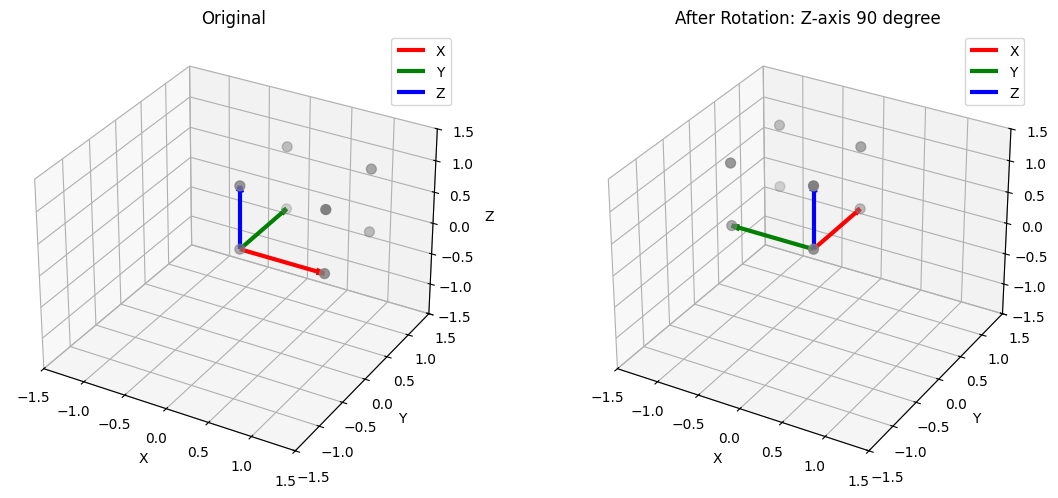

In [14]:
def visualize_rotation(R, title="Rotation Visualization"):
    """회전 행렬의 효과를 3D로 시각화"""
    fig = plt.figure(figsize=(12, 5))
    
    # 원본 좌표축
    axes_original = np.eye(3)
    # 회전된 좌표축
    axes_rotated = R @ axes_original
    
    # 큐브의 꼭짓점들
    cube_vertices = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # 하단
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]   # 상단
    ]).T
    
    # Subplot 1: 원본
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Original")
    
    # 좌표축 그리기
    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']
    for i in range(3):
        ax1.quiver(0, 0, 0, axes_original[0, i], axes_original[1, i], axes_original[2, i],
                   color=colors[i], arrow_length_ratio=0.1, linewidth=3, label=labels[i])
    
    # 큐브 그리기
    ax1.scatter(cube_vertices[0], cube_vertices[1], cube_vertices[2], c='gray', s=50)
    
    # Subplot 2: 회전 후
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title(f"After Rotation: {title}")
    
    # 회전된 좌표축
    for i in range(3):
        ax2.quiver(0, 0, 0, axes_rotated[0, i], axes_rotated[1, i], axes_rotated[2, i],
                   color=colors[i], arrow_length_ratio=0.1, linewidth=3, label=labels[i])
    
    # 회전된 큐브
    cube_rotated = R @ cube_vertices
    ax2.scatter(cube_rotated[0], cube_rotated[1], cube_rotated[2], c='gray', s=50)
    
    # 축 설정
    for ax in [ax1, ax2]:
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.5, 1.5])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 다양한 회전 시각화
rotations = [
    (np.array([0, 0, np.pi/2]), "Z-axis 90 degree"),
    (np.array([np.pi/2, 0, 0]), "X-axis 90 degree"),
    (np.array([0, np.pi/2, 0]), "Y-axis 90 degree"),
    (np.array([np.pi/4, np.pi/4, 0]), "X,Y-axis 45 degree")
]

for rotvec, title in rotations[:1]:  # 첫 번째 예제만 표시
    R = rotvec_to_rotmat(rotvec)
    visualize_rotation(R, title)

## 2. SE(3) 변환 - 포즈의 완전한 표현 🤖

이론 Section 3에서 배운 SE(3)를 코드로 구현해봅시다. SE(3)는 SLAM에서 로봇의 포즈를 표현하는 핵심입니다.

### 🏗️ SE3Transform 클래스 설계

```python
SE3Transform = 회전(SO(3)) + 이동(R³)
           = [R  t]  ← 4x4 동차 변환 행렬
             [0  1]
```

#### 🎯 클래스의 핵심 메서드
1. **`matrix()`** - 4x4 행렬 표현 (렌더링, 변환에 사용)
2. **`inverse()`** - 역변환 (중요! 자주 사용됨)
3. **`compose()`** - 변환 합성 (T1 * T2)
4. **`transform_point()`** - 3D 점 변환

#### ⚡ 구현 시 주의사항
- **역변환 공식**: T⁻¹ = [R^T, -R^T·t]
- **합성 순서**: T1 * T2 ≠ T2 * T1 (비가환!)
- **메모리 효율**: R과 t를 분리 저장

### 🔗 SLAM에서의 활용
```python
# 로봇이 이동하는 시나리오
T_world_robot_t0 = SE3Transform(...)  # 시간 t0의 포즈
T_robot_t0_robot_t1 = SE3Transform(...)  # 상대 이동
T_world_robot_t1 = T_world_robot_t0.compose(T_robot_t0_robot_t1)  # 새 포즈
```

In [5]:
class SE3Transform:
    """SE(3) 변환을 다루는 클래스"""
    
    def __init__(self, R=None, t=None):
        """SE(3) 변환 초기화
        
        Args:
            R: 3x3 회전 행렬 (기본값: 단위 행렬)
            t: 3x1 이동 벡터 (기본값: 영벡터)
        """
        self.R = np.eye(3) if R is None else R
        self.t = np.zeros(3) if t is None else t
    
    def matrix(self):
        """4x4 동차 변환 행렬 반환"""
        T = np.eye(4)
        T[:3, :3] = self.R
        T[:3, 3] = self.t
        return T
    
    def inverse(self):
        """SE(3) 역변환 계산
        
        T^{-1} = [R^T  -R^T*t]
                 [0     1    ]
        """
        R_inv = self.R.T
        t_inv = -R_inv @ self.t
        return SE3Transform(R_inv, t_inv)
    
    def compose(self, other):
        """두 SE(3) 변환의 합성 (self * other)
        
        T1 * T2 = [R1*R2  R1*t2 + t1]
                  [0      1        ]
        """
        R_new = self.R @ other.R
        t_new = self.R @ other.t + self.t
        return SE3Transform(R_new, t_new)
    
    def transform_point(self, point):
        """3D 점을 변환"""
        return self.R @ point + self.t
    
    def __repr__(self):
        return f"SE3Transform:\nR:\n{self.R}\nt: {self.t}"

print("✅ SE3Transform 클래스가 정의되었습니다!")

✅ SE3Transform 클래스가 정의되었습니다!


### 🧪 실습 2: SE(3) 변환 연산

SE(3) 그룹의 핵심 성질들을 코드로 검증해봅시다.

#### 🎯 검증할 그룹 성질
1. **닫힘성**: T1 * T2 ∈ SE(3)
2. **결합법칙**: (T1 * T2) * T3 = T1 * (T2 * T3)
3. **항등원**: T * I = T
4. **역원**: T * T⁻¹ = I

#### 💡 실무에서 자주 하는 실수
1. **변환 순서 혼동**
   ```python
   # ❌ 잘못된 예
   T_AC = T_BA * T_CB  # 인덱스가 맞지 않음!
   
   # ✅ 올바른 예  
   T_AC = T_AB * T_BC  # B가 연결고리
   ```

2. **역변환 계산 오류**
   ```python
   # ❌ 단순 역행렬 (느림)
   T_inv = np.linalg.inv(T.matrix())
   
   # ✅ SE(3) 구조 활용 (빠름)
   T_inv = T.inverse()  # R^T와 -R^T*t 직접 계산
   ```

#### 🔍 결과 해석
- 항등 변환 오차가 1e-15 수준 → 수치적으로 안정
- 이는 double precision의 한계

In [6]:
# 1. 두 개의 SE(3) 변환 생성
# T1: Z축 기준 90도 회전 + (1, 0, 0) 이동
R1 = rotvec_to_rotmat(np.array([0, 0, np.pi/2]))
t1 = np.array([1, 0, 0])
T1 = SE3Transform(R1, t1)

# T2: X축 기준 90도 회전 + (0, 1, 0) 이동
R2 = rotvec_to_rotmat(np.array([np.pi/2, 0, 0]))
t2 = np.array([0, 1, 0])
T2 = SE3Transform(R2, t2)

print("T1 (Z축 90도 회전 + X방향 1 이동):")
print(T1)
print("\nT2 (X축 90도 회전 + Y방향 1 이동):")
print(T2)

# 2. 변환의 합성
T12 = T1.compose(T2)
print("\n\nT1 * T2 (합성 변환):")
print(T12)

# 3. 역변환
T1_inv = T1.inverse()
print("\n\nT1^{-1} (역변환):")
print(T1_inv)

# 4. 검증: T1 * T1^{-1} = I
identity_check = T1.compose(T1_inv)
print("\n\nT1 * T1^{-1} (단위 변환이어야 함):")
print(identity_check)
print(f"\n회전 부분 오차: {np.linalg.norm(identity_check.R - np.eye(3)):.6f}")
print(f"이동 부분 오차: {np.linalg.norm(identity_check.t):.6f}")

T1 (Z축 90도 회전 + X방향 1 이동):
SE3Transform:
R:
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
t: [1 0 0]

T2 (X축 90도 회전 + Y방향 1 이동):
SE3Transform:
R:
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
t: [0 1 0]


T1 * T2 (합성 변환):
SE3Transform:
R:
[[ 0. -0.  1.]
 [ 1.  0. -0.]
 [ 0.  1.  0.]]
t: [0. 0. 0.]


T1^{-1} (역변환):
SE3Transform:
R:
[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]
t: [-0.  1.  0.]


T1 * T1^{-1} (단위 변환이어야 함):
SE3Transform:
R:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t: [0. 0. 0.]

회전 부분 오차: 0.000000
이동 부분 오차: 0.000000


### 📊 시각화: SE(3) 변환의 연쇄 적용

로봇이 실제로 이동하는 시나리오를 시각화해봅시다.

#### 🤖 시뮬레이션 시나리오
```
시작 → 전진 1m → 좌회전 90° → 전진 1m → 좌회전 90° → 전진 1m
```

이는 실제 로봇이 사각형 경로를 따라 이동하는 것과 같습니다.

#### 🔍 관찰 포인트
1. **누적 변환**: 각 단계의 변환이 누적됨
2. **좌표축 회전**: 로봇의 heading 방향 변화
3. **경로 형태**: 예상한 사각형이 나오는가?

#### 💡 SLAM 연결고리
- 각 `robot_movements[i]`는 **오도메트리 측정값**
- 누적된 포즈는 **추정된 궤적**
- 실제로는 노이즈로 인해 완벽한 사각형이 안 됨!

#### 🛠️ 디버깅 팁
경로가 이상하다면:
1. 회전이 로봇 좌표계 기준인지 확인
2. 이동이 회전 전/후 중 언제 적용되는지 확인
3. 변환 합성 순서 재확인

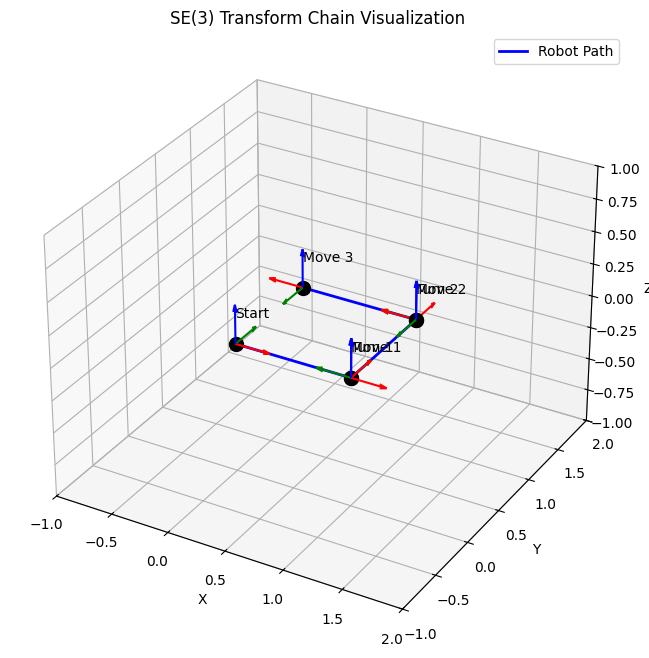

In [7]:
def visualize_se3_chain(transforms, labels=None):
    """SE(3) 변환의 연쇄를 시각화"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 누적 변환 계산
    cumulative_transforms = [SE3Transform()]  # 항등 변환으로 시작
    for T in transforms:
        cumulative_transforms.append(cumulative_transforms[-1].compose(T))
    
    # 경로 그리기
    positions = np.array([T.t for T in cumulative_transforms])
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
            'b-', linewidth=2, label='Robot Path')
    
    # 각 위치에서의 좌표계 그리기
    colors = ['r', 'g', 'b']
    for i, T in enumerate(cumulative_transforms):
        # 위치
        pos = T.t
        ax.scatter(*pos, s=100, c='black')
        
        # 좌표축
        for j in range(3):
            axis = T.R[:, j] * 0.3  # 축 길이 조정
            ax.quiver(pos[0], pos[1], pos[2], 
                     axis[0], axis[1], axis[2],
                     color=colors[j], arrow_length_ratio=0.2)
        
        # 라벨
        if labels and i < len(labels):
            ax.text(pos[0], pos[1], pos[2] + 0.2, labels[i], fontsize=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('SE(3) Transform Chain Visualization')
    ax.legend()
    
    # 축 범위 설정
    all_points = positions
    margin = 1.0
    ax.set_xlim([all_points[:, 0].min() - margin, all_points[:, 0].max() + margin])
    ax.set_ylim([all_points[:, 1].min() - margin, all_points[:, 1].max() + margin])
    ax.set_zlim([all_points[:, 2].min() - margin, all_points[:, 2].max() + margin])
    
    plt.show()

# 로봇 움직임 시뮬레이션
robot_movements = [
    SE3Transform(np.eye(3), np.array([1, 0, 0])),  # 전진
    SE3Transform(rotvec_to_rotmat(np.array([0, 0, np.pi/2])), np.array([0, 0, 0])),  # 좌회전
    SE3Transform(np.eye(3), np.array([1, 0, 0])),  # 전진
    SE3Transform(rotvec_to_rotmat(np.array([0, 0, np.pi/2])), np.array([0, 0, 0])),  # 좌회전
    SE3Transform(np.eye(3), np.array([1, 0, 0])),  # 전진
]

labels = ['Start', 'Move 1', 'Turn 1', 'Move 2', 'Turn 2', 'Move 3']

visualize_se3_chain(robot_movements, labels)

## 3. Tangent Space와 Manifold - 최적화의 핵심 🎯

이론 Section 4-5에서 배운 Lie 대수와 매니폴드 개념을 코드로 구현해봅시다.

### 🌍 왜 Tangent Space가 필요한가?

#### ❌ SE(3)에서 직접 최적화의 문제점
```python
# 잘못된 예: 두 포즈의 "평균"?
T_avg = (T1 + T2) / 2  # 이건 SE(3)가 아님!
```

#### ✅ Tangent Space를 통한 해결
```python
# 올바른 방법:
xi1 = log(T1)  # SE(3) → se(3)
xi2 = log(T2)  
xi_avg = (xi1 + xi2) / 2  # se(3)는 벡터 공간!
T_avg = exp(xi_avg)  # se(3) → SE(3)
```

### 🔧 구현할 핵심 함수들

1. **`se3_exp(xi)`**: se(3) → SE(3) (지수 맵)
   - Rodrigues 공식 사용
   - 작은 각도 특별 처리

2. **`se3_log(T)`**: SE(3) → se(3) (로그 맵)
   - 회전 부분 추출
   - V 행렬 역계산

3. **`retract(T, delta)`**: 최적화 업데이트
   - T_new = T * exp(delta)
   - SymForce 스타일!

4. **`local_coordinates(T1, T2)`**: 포즈 차이 계산
   - delta = log(T1⁻¹ * T2)
   - 에러 계산에 필수

### 💡 실전 활용
```python
# SLAM 최적화 스텝
for iteration in range(max_iter):
    error = local_coordinates(T_measured, T_current)
    delta = -learning_rate * compute_gradient(error)
    T_current = retract(T_current, delta)
```

In [8]:
def skew_symmetric(v):
    """3D 벡터를 skew-symmetric 행렬로 변환
    
    [v]_× = [ 0   -vz   vy]
            [ vz   0   -vx]
            [-vy   vx   0 ]
    """
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def se3_exp(xi):
    """se(3) → SE(3) exponential map
    
    Args:
        xi: 6D vector [translation, rotation]
        
    Returns:
        T: SE(3) transformation
    """
    v = xi[:3]  # translation part
    w = xi[3:]  # rotation part
    
    # Rotation part: Rodrigues' formula
    theta = np.linalg.norm(w)
    if theta < 1e-6:
        # First order approximation for small angles
        R = np.eye(3) + skew_symmetric(w)
        V = np.eye(3)
    else:
        w_hat = w / theta
        W = skew_symmetric(w_hat)
        R = np.eye(3) + np.sin(theta) * W + (1 - np.cos(theta)) * (W @ W)
        
        # V matrix for translation
        V = np.eye(3) + ((1 - np.cos(theta)) / theta) * W + ((theta - np.sin(theta)) / theta) * (W @ W)
    
    t = V @ v
    return SE3Transform(R, t)

def se3_log(T):
    """SE(3) → se(3) logarithm map
    
    Args:
        T: SE3Transform object
        
    Returns:
        xi: 6D vector [translation, rotation]
    """
    # Rotation part
    w = rotmat_to_rotvec(T.R)
    theta = np.linalg.norm(w)
    
    # Translation part
    if theta < 1e-6:
        V_inv = np.eye(3)
    else:
        w_hat = w / theta
        W = skew_symmetric(w_hat)
        # Inverse of V matrix
        V_inv = np.eye(3) - 0.5 * W + (1/theta**2) * (1 - (theta * np.sin(theta))/(2 * (1 - np.cos(theta)))) * (W @ W)
    
    v = V_inv @ T.t
    return np.concatenate([v, w])

# SymForce의 retract와 local_coordinates 구현
def retract(T, delta):
    """SE(3) 원소를 tangent 벡터로 섭동
    
    SymForce의 핵심 연산 중 하나입니다.
    T_new = T * exp(delta)
    
    Args:
        T: SE3Transform 객체
        delta: 6D tangent 벡터
        
    Returns:
        T_new: 섭동된 SE3Transform
    """
    return T.compose(se3_exp(delta))

def local_coordinates(T1, T2):
    """두 SE(3) 원소 간의 tangent space 차이
    
    SymForce의 핵심 연산 중 하나입니다.
    delta = log(T1^{-1} * T2)
    
    Args:
        T1, T2: SE3Transform 객체들
        
    Returns:
        delta: 6D tangent 벡터
    """
    return se3_log(T1.inverse().compose(T2))

print("✅ Exponential/Logarithm map과 SymForce 스타일 연산이 정의되었습니다!")

✅ Exponential/Logarithm map과 SymForce 스타일 연산이 정의되었습니다!


### 🧪 실습 3: Tangent Space 연산과 SymForce 패턴

이제 최적화의 핵심인 exp/log 맵과 SymForce 스타일 연산을 테스트해봅시다.

#### 🎯 검증 목표
1. **exp ∘ log = identity**: 왕복 변환의 정확성
2. **retract의 선형성**: 작은 delta에 대해 선형 근사
3. **local_coordinates의 일관성**: 차이 계산의 정확성

#### 🔍 결과 해석
- **Tangent vector**: [tx, ty, tz, rx, ry, rz]
  - 앞 3개: 이동 성분
  - 뒤 3개: 회전 성분 (축 * 각도)
- **복원 오차 ~1e-15**: 수치적으로 정확
- **delta 차이 ~0.07**: 비선형성 때문 (정상!)

#### 💡 최적화에서의 의미
```python
# Gauss-Newton 업데이트
while not converged:
    # 1. 에러 계산 (tangent space)
    error = local_coordinates(T_target, T_current)
    
    # 2. Jacobian과 Hessian 계산
    J = compute_jacobian(...)
    H = J.T @ J
    
    # 3. 업데이트 계산 (tangent space)
    delta = -np.linalg.solve(H, J.T @ error)
    
    # 4. 포즈 업데이트 (manifold)
    T_current = retract(T_current, delta)
```

#### ⚠️ 주의사항
- delta가 클 때는 여러 번 나눠서 적용
- 수렴 판정은 ||delta|| < threshold로

In [9]:
# 1. SE(3) 변환을 tangent vector로 변환
T = SE3Transform(
    rotvec_to_rotmat(np.array([0.1, 0.2, 0.3])),
    np.array([1, 2, 3])
)

print("원본 SE(3) 변환:")
print(T)

# 2. Log map: SE(3) → se(3)
xi = se3_log(T)
print(f"\nTangent vector (se(3)): {xi}")
print(f"  - Translation part: {xi[:3]}")
print(f"  - Rotation part: {xi[3:]}")

# 3. Exp map: se(3) → SE(3)
T_restored = se3_exp(xi)
print("\n복원된 SE(3) 변환:")
print(T_restored)

# 4. 오차 검증
print("\n✅ 변환 정확도:")
print(f"  - 회전 오차: {np.linalg.norm(T.R - T_restored.R):.6f}")
print(f"  - 이동 오차: {np.linalg.norm(T.t - T_restored.t):.6f}")

# 5. SymForce 스타일 연산 테스트
print("\n\n🔧 SymForce 스타일 연산 테스트:")

# retract 연산: 작은 섭동 적용
delta = np.array([0.1, 0.05, -0.1, 0.02, -0.03, 0.01])  # 작은 tangent 벡터
T_perturbed = retract(T, delta)
print(f"\n원본 위치: {T.t}")
print(f"섭동 후 위치: {T_perturbed.t}")

# local_coordinates 연산: 두 포즈 간 차이 계산
diff = local_coordinates(T, T_perturbed)
print(f"\n계산된 차이 (should be close to delta): {diff}")
print(f"입력 delta와의 차이: {np.linalg.norm(diff - delta):.6f}")

# 최적화에서의 활용 예시
print("\n\n📈 최적화에서의 활용:")
print("1. 현재 포즈: T")
print("2. 최적화가 계산한 업데이트: delta (tangent space)")
print("3. 새로운 포즈: T_new = retract(T, delta)")
print("4. 두 포즈 간 에러: error = local_coordinates(T_measured, T_predicted)")

원본 SE(3) 변환:
SE3Transform:
R:
[[ 0.9358 -0.2832  0.2102]
 [ 0.3029  0.9506 -0.068 ]
 [-0.1805  0.1273  0.9753]]
t: [1 2 3]

Tangent vector (se(3)): [1.  2.  3.  0.1 0.2 0.3]
  - Translation part: [1. 2. 3.]
  - Rotation part: [0.1 0.2 0.3]

복원된 SE(3) 변환:
SE3Transform:
R:
[[ 0.9358 -0.2832  0.2102]
 [ 0.3029  0.9506 -0.068 ]
 [-0.1805  0.1273  0.9753]]
t: [1. 2. 3.]

✅ 변환 정확도:
  - 회전 오차: 0.000000
  - 이동 오차: 0.000000


🔧 SymForce 스타일 연산 테스트:

원본 위치: [1 2 3]
섭동 후 위치: [1.0595 2.0863 2.8927]

계산된 차이 (should be close to delta): [ 0.0598  0.0084 -0.1445  0.02   -0.03    0.01  ]
입력 delta와의 차이: 0.072969


📈 최적화에서의 활용:
1. 현재 포즈: T
2. 최적화가 계산한 업데이트: delta (tangent space)
3. 새로운 포즈: T_new = retract(T, delta)
4. 두 포즈 간 에러: error = local_coordinates(T_measured, T_predicted)


## 4. SLAM에서의 실제 응용: Relative Pose Error 🎯

이론 Section 7의 내용을 실제 코드로 구현해봅시다. 이것이 바로 Pose Graph Optimization의 핵심입니다!

### 📐 Relative Pose Error의 의미

```
실제 경로:  A ----측정값----> B
             \              /
              \  예측값   /
               \        /
                \    /
                에러
```

#### 수학적 정의
```python
T_error = T_measured⁻¹ * T_predicted
        = T_measured⁻¹ * (Ti⁻¹ * Tj)
        
error_vector = log(T_error)  # 6D vector in se(3)
```

### 🎯 왜 이렇게 계산하나요?

1. **SE(3)에서 뺄셈이 없음**: T_measured - T_predicted ❌
2. **상대 변환으로 표현**: "측정값 기준으로 예측이 얼마나 틀렸나"
3. **Tangent space로 변환**: 6D 벡터로 만들어 최적화 가능

### 💡 SLAM에서의 활용

```python
# Pose Graph의 엣지 에러
for edge in pose_graph.edges:
    i, j = edge.nodes
    T_ij_measured = edge.measurement
    
    # 현재 포즈 추정값으로 예측
    T_ij_predicted = T[i].inverse() @ T[j]
    
    # 에러 계산
    error = compute_relative_pose_error(T[i], T[j], T_ij_measured)
    
    # 비용 함수에 추가
    cost += error.T @ information_matrix @ error
```

### 🔍 에러 벡터 해석
- **[0-2]**: 위치 오차 (미터)
- **[3-5]**: 회전 오차 (라디안)
- 크기가 클수록 측정값과 현재 추정값의 불일치가 큼

In [10]:
def compute_relative_pose_error(Ti, Tj, Tij_measured):
    """두 포즈 간의 relative pose error 계산
    
    에러는 다음과 같이 정의됩니다:
    T_error = T_ij_measured^{-1} * T_i^{-1} * T_j
    
    Args:
        Ti, Tj: 포즈 i와 j의 SE(3) 변환
        Tij_measured: 측정된 상대 변환
        
    Returns:
        error_vector: 6D error vector [translation, rotation]
    """
    # 예측된 상대 변환
    Tij_predicted = Ti.inverse().compose(Tj)
    
    # 에러 변환
    T_error = Tij_measured.inverse().compose(Tij_predicted)
    
    # Tangent space로 변환
    error_vector = se3_log(T_error)
    
    return error_vector, T_error

# 예제: 두 포즈와 측정값
# 포즈 i: 원점
Ti = SE3Transform()

# 포즈 j: 실제로는 (2, 1, 0)에 있고 30도 회전
Tj = SE3Transform(
    rotvec_to_rotmat(np.array([0, 0, np.pi/6])),
    np.array([2, 1, 0])
)

# 측정값: 약간의 노이즈가 있음
Tij_measured = SE3Transform(
    rotvec_to_rotmat(np.array([0, 0, np.pi/6 + 0.05])),  # 회전에 노이즈
    np.array([2.1, 0.9, 0])  # 이동에 노이즈
)

# 에러 계산
error_vector, T_error = compute_relative_pose_error(Ti, Tj, Tij_measured)

print("포즈 간 상대 에러 분석:")
print(f"\n에러 벡터 (6D): {error_vector}")
print(f"  - Translation error: {error_vector[:3]}")
print(f"  - Rotation error: {error_vector[3:]}")
print(f"\n총 에러 크기: {np.linalg.norm(error_vector):.4f}")

포즈 간 상대 에러 분석:

에러 벡터 (6D): [-0.0964  0.1119  0.      0.      0.     -0.05  ]
  - Translation error: [-0.0964  0.1119  0.    ]
  - Rotation error: [ 0.    0.   -0.05]

총 에러 크기: 0.1559


## 5. 핵심 요약 및 실전 체크리스트 ✅

### 🎓 오늘 배운 핵심 개념과 구현

#### 1. **회전 표현법 마스터**
- ✅ 쿼터니언 ↔ 회전행렬 ↔ 회전벡터 변환
- ✅ 각 표현법의 장단점과 사용 시기 이해
- ✅ 수치적으로 안정적인 변환 구현

#### 2. **SE(3) 변환 완벽 이해**
- ✅ SE3Transform 클래스 구현
- ✅ 그룹 연산 (합성, 역변환) 정확히 구현
- ✅ 실제 로봇 움직임 시뮬레이션

#### 3. **Tangent Space 활용**
- ✅ exp/log 맵 구현으로 매니폴드 ↔ 벡터공간 변환
- ✅ retract/local_coordinates로 최적화 가능하게
- ✅ SymForce 스타일 패턴 익히기

#### 4. **SLAM 실전 응용**
- ✅ Relative Pose Error 계산 구현
- ✅ Pose Graph Optimization의 기초 이해
- ✅ 에러 메트릭의 의미 파악

### 💡 실무 개발 시 체크리스트

```python
# 1. 회전 작업 시
□ 짐벌락 위험이 있는가? → 쿼터니언 사용
□ 최적화가 필요한가? → 회전 벡터 사용
□ 직관적 디버깅이 중요한가? → 회전 행렬 사용

# 2. SE(3) 변환 시
□ 변환 순서가 올바른가? (인덱스 체크)
□ 역변환을 효율적으로 계산했는가?
□ 수치 오차가 누적되지 않는가?

# 3. 최적화 구현 시
□ Tangent space에서 업데이트하고 있는가?
□ Manifold 제약을 유지하고 있는가?
□ 에러 계산이 올바른가?

# 4. 디버깅 시
□ 단위 테스트를 작성했는가?
□ 극단적인 경우를 테스트했는가? (0, π, 특이점)
□ 시각화로 결과를 확인했는가?
```

### 🚀 다음 단계

**Chapter 2 예고**: g2o 파일 포맷 이해하기
- 이번에 배운 SE(3) 변환이 실제 SLAM 데이터에 어떻게 저장되는지
- 대규모 포즈 그래프를 다루는 방법
- 실제 데이터셋으로 작업하기

### 🔑 기억해야 할 한 가지

> **"SLAM은 불확실성과의 싸움입니다. 올바른 수학적 도구(SO(3), SE(3), Lie theory)를 사용하면, 이 싸움에서 이길 수 있습니다."**

### 📚 추가 학습 자료
- **코드 심화**: [SymForce 튜토리얼](https://symforce.org)
- **이론 심화**: Barfoot의 "State Estimation for Robotics"
- **실전 프로젝트**: nano-pgo 전체 코드 분석

수고하셨습니다! 🎉

## 🏋️ 연습 문제

실습을 마무리하며 다음 문제들을 풀어보세요. 해답은 주석으로 제공됩니다.

### 📝 문제 1: 회전 합성의 비가환성
두 회전 R1(X축 45도)과 R2(Y축 30도)를 순서대로 적용했을 때와 역순으로 적용했을 때의 차이를 확인하세요.

**힌트**: 
- `R_total_1 = R2 @ R1` vs `R_total_2 = R1 @ R2`
- 결과 시각화하여 차이 확인
- 회전의 비가환성 이해

### 📝 문제 2: SE(3) 보간
두 SE(3) 변환 사이를 부드럽게 보간하는 함수를 작성하세요.

**힌트**:
```python
def interpolate_se3(T1, T2, alpha):
    """
    T1과 T2 사이를 alpha (0~1) 비율로 보간
    alpha=0: T1, alpha=1: T2
    """
    # 1. T1에서 T2로의 상대 변환 계산
    # 2. Tangent space에서 보간
    # 3. 결과를 T1에서 적용
    pass
```

### 📝 문제 3: 노이즈 민감도 분석
측정 노이즈가 relative pose error에 미치는 영향을 분석하세요.

**힌트**:
- 다양한 노이즈 레벨 (0.01, 0.1, 1.0 rad/m)
- 에러의 평균과 표준편차 계산
- 그래프로 시각화

### 📝 도전 과제: Mini SLAM
간단한 1D SLAM을 구현해보세요!
- 로봇이 1차원 선상에서 움직임
- 노이즈가 있는 오도메트리
- 루프 클로저로 보정

In [ ]:
# 여기에 연습 문제를 풀어보세요!
# 예제 코드:

# 문제 1 시작
# R1 = rotvec_to_rotmat(np.array([np.pi/4, 0, 0]))  # X축 45도
# R2 = rotvec_to_rotmat(np.array([0, np.pi/6, 0]))  # Y축 30도
# ...


## 6. 수치적 안정성과 Epsilon 처리 - 실전 구현 🛡️

이론 Section 6에서 배운 수치적 안정성을 실제 코드로 구현해봅시다. 이는 SymForce의 핵심 철학 중 하나입니다.

### 🚨 왜 Epsilon이 생명을 구하는가?

#### 실제 발생하는 문제들
```python
# ❌ 위험한 코드 - 실제 프로덕션에서 크래시!
theta = 1e-20  # 매우 작은 각도
sin_over_theta = np.sin(theta) / theta  # 0/0 = NaN!

# ✅ 안전한 코드 - SymForce 스타일
if abs(theta) < epsilon:
    sin_over_theta = 1.0 - theta**2 / 6.0  # Taylor 근사
else:
    sin_over_theta = np.sin(theta) / theta
```

### 📊 특이점 지도

| 함수 | 특이점 | 해결책 |
|------|--------|--------|
| sin(θ)/θ | θ = 0 | Taylor: 1 - θ²/6 |
| (1-cos(θ))/θ | θ = 0 | Taylor: θ/2 |
| atan2(y,x) | x=y=0 | 기본값 반환 |
| normalize(v) | \|\|v\|\|=0 | v/(\|\|v\|\|+ε) |

### 🔧 구현 패턴

1. **Taylor Series 근사**
   - 특이점 근처에서 다항식 근사
   - 연속성과 미분가능성 보장

2. **Epsilon 추가**
   - 분모에 작은 값 더하기
   - 0으로 나누기 방지

3. **조건부 분기**
   - 특이점 근처 특별 처리
   - 일반 경우와 분리

### 💡 실전 경험
> "한 번은 로봇이 정확히 180도 회전했을 때 시스템이 크래시했습니다. 
> 로그를 보니 회전 벡터에서 쿼터니언 변환 중 NaN이 발생했더군요. 
> Epsilon 처리를 추가한 후로는 문제가 없습니다." - SLAM 엔지니어

### 🎯 테스트 전략
```python
# 극단적인 경우 모두 테스트
test_angles = [0, 1e-10, 1e-6, 0.1, π/2, π-1e-6, π, 2π]
for angle in test_angles:
    result = your_function(angle)
    assert not np.isnan(result).any()
    assert not np.isinf(result).any()
```

In [15]:
def safe_normalize(v, epsilon=1e-10):
    """벡터를 안전하게 정규화 (영벡터 처리)
    
    SymForce 스타일의 epsilon 처리 예제입니다.
    """
    norm = np.linalg.norm(v)
    # 영벡터 근처에서의 특이점 회피
    norm_safe = norm + epsilon
    return v / norm_safe, norm

def sin_theta_over_theta(theta, epsilon=1e-10):
    """sin(θ)/θ 함수의 안전한 계산
    
    θ → 0일 때 sin(θ)/θ → 1 이지만, 
    수치적으로 0/0이 되는 것을 방지합니다.
    """
    if abs(theta) < epsilon:
        # Taylor series approximation for small angles
        # sin(θ)/θ ≈ 1 - θ²/6 + θ⁴/120 - ...
        return 1.0 - theta**2 / 6.0
    else:
        return np.sin(theta) / theta

def one_minus_cos_theta_over_theta(theta, epsilon=1e-10):
    """(1-cos(θ))/θ 함수의 안전한 계산"""
    if abs(theta) < epsilon:
        # Taylor series: (1-cos(θ))/θ ≈ θ/2 - θ³/24 + ...
        return theta / 2.0
    else:
        return (1.0 - np.cos(theta)) / theta

# 개선된 se3_exp 함수 (epsilon 처리 포함)
def se3_exp_safe(xi, epsilon=1e-10):
    """수치적으로 안정적인 se(3) → SE(3) exponential map"""
    v = xi[:3]
    w = xi[3:]
    
    theta = np.linalg.norm(w)
    
    if theta < epsilon:
        # Small angle approximation
        R = np.eye(3) + skew_symmetric(w)
        t = v  # V ≈ I for small angles
    else:
        w_hat = w / theta
        W = skew_symmetric(w_hat)
        
        # Rodrigues' formula with safe functions
        sin_over_theta = sin_theta_over_theta(theta)
        one_minus_cos_over_theta = one_minus_cos_theta_over_theta(theta)
        
        R = np.eye(3) + sin_over_theta * theta * W + \
            one_minus_cos_over_theta * theta * (W @ W)
        
        # V matrix for translation
        V = np.eye(3) + one_minus_cos_over_theta * W + \
            (1.0 - sin_over_theta) * (W @ W)
        
        t = V @ v
    
    return SE3Transform(R, t)

# 테스트: 아주 작은 회전에서의 수치적 안정성
print("🔬 수치적 안정성 테스트:")

# 점점 작아지는 회전 각도들
angles = [1.0, 0.1, 0.01, 1e-6, 1e-10, 0.0]

for angle in angles:
    xi = np.array([1, 0, 0, 0, 0, angle])  # Z축 회전
    
    # 일반 버전과 안전한 버전 비교
    try:
        T_normal = se3_exp(xi)
        error_normal = 0
    except:
        error_normal = float('inf')
    
    T_safe = se3_exp_safe(xi)
    
    print(f"\n각도 = {angle:e}")
    print(f"  안전한 버전 - 회전 행렬 행렬식: {np.linalg.det(T_safe.R):.10f} (1이어야 함)")
    print(f"  안전한 버전 - 직교성 오차: {np.linalg.norm(T_safe.R @ T_safe.R.T - np.eye(3)):.2e}")
    
print("\n✅ Epsilon 처리로 모든 경우에서 수치적으로 안정적인 결과를 얻었습니다!")

🔬 수치적 안정성 테스트:

각도 = 1.000000e+00
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 3.31e-17

각도 = 1.000000e-01
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 9.16e-18

각도 = 1.000000e-02
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 1.10e-18

각도 = 1.000000e-06
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 1.57e-16

각도 = 1.000000e-10
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 0.00e+00

각도 = 0.000000e+00
  안전한 버전 - 회전 행렬 행렬식: 1.0000000000 (1이어야 함)
  안전한 버전 - 직교성 오차: 0.00e+00

✅ Epsilon 처리로 모든 경우에서 수치적으로 안정적인 결과를 얻었습니다!
